In [20]:
# Script to extract the data over country-shapes

In [1]:
import pandas as pd
import geopandas as gpd
# Operations on geometries
import shapely
import numpy as np
import math
import xarray as xr
import regionmask
import dask.array as da
# plotting
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

In [2]:
# Path files (change the paths accordingly)
mypath = '/storage/workspaces/giub_hydro/hydro/data'
era_dir = mypath + '/ERA5/'
sh_file = '/ref-nuts-2016-10m.shp/NUTS_RG_10M_2016_4326_LEVL_0.shp'
t2m = 'Daymean_era5_T2M_EU_19790101-20210905.nc'

In [3]:
nuts = gpd.read_file(mypath+sh_file)

In [4]:
nuts.head()

,LEVL_CODE,NUTS_ID,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,0,AL,AL,SHQIPËRIA,SHQIPËRIA,0,0,0,AL,"POLYGON ((19.82698 42.46950, 19.83939 42.46950..."
1,0,AT,AT,ÖSTERREICH,ÖSTERREICH,0,0,0,AT,"POLYGON ((15.54245 48.90770, 15.75363 48.85218..."
2,0,BE,BE,BELGIQUE-BELGIË,BELGIQUE-BELGIË,0,0,0,BE,"POLYGON ((5.10218 51.42900, 5.08780 51.38230, ..."
3,0,NL,NL,NEDERLAND,NEDERLAND,0,0,0,NL,"MULTIPOLYGON (((6.87491 53.40801, 6.91836 53.3..."
4,0,PL,PL,POLSKA,POLSKA,0,0,0,PL,"MULTIPOLYGON (((18.95003 54.35831, 19.35966 54..."


In [5]:
t2m_dat = xr.open_mfdataset(era_dir + t2m, chunks = {'time': 10})
lons = t2m_dat.lon
lats = t2m_dat.lat
#t2m_dat

In [6]:
mslp_dat = xr.open_mfdataset(f'{era_dir}mslp/*.nc', combine='by_coords', parallel = True).MSL

/storage/workspaces/giub_hydro/hydro/PyPackages/lib/python3.8/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [7]:
mslp_dat

<xarray.DataArray 'MSL' (time: 15555, lat: 201, lon: 321)>
dask.array<where, shape=(15555, 201, 321), dtype=float32, chunksize=(945, 201, 321), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01T11:30:00 ... 2021-09-02T10:00:00
  * lon      (lon) float32 -40.0 -39.75 -39.5 -39.25 ... 39.25 39.5 39.75 40.0
  * lat      (lat) float32 30.0 30.25 30.5 30.75 31.0 ... 79.25 79.5 79.75 80.0
Attributes:
    standard_name:  air_pressure_at_sea_level
    long_name:      Mean sea-level pressure
    units:          Pa
    code:           151
    table:          128
    cell_methods:   time: mean
    institution:    ECMWF

In [8]:
mslp_dat = xr.open_mfdataset(f'{era_dir}mslp/*.nc', combine='by_coords', parallel = True).MSL

/storage/workspaces/giub_hydro/hydro/PyPackages/lib/python3.8/site-packages/xarray/core/indexing.py:1226: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [9]:
gp_dat = xr.open_mfdataset(f'{era_dir}geopotential/*.nc', combine='by_coords', parallel = True).z

In [10]:
nn = len(nuts.NUTS_ID)

In [11]:
# Define the mask
nuts_mask_poly = regionmask.Regions(name = 'nuts_mask', numbers = list(range(0,nn)), names = list(nuts.NUTS_ID), abbrevs = list(nuts.NUTS_ID), outlines = list(nuts.geometry.values[i] for i in range(0,nn)))
print(nuts_mask_poly)

<regionmask.Regions>
Name:     nuts_mask

Regions:
 0 AL AL
 1 AT AT
 2 BE BE
 3 NL NL
 4 PL PL
.. .. ..
32 ME ME
33 MK MK
34 UK UK
35 MT MT
36 FR FR

[37 regions]


In [12]:
# Extract the ID for Switzerland
ID_CH = 11

In [13]:
# Important: pay attention to incresing (or decreasin order of latitude)
mask = nuts_mask_poly.mask(t2m_dat.isel(time = 0).sel(lat = slice(80,30), lon  = slice(-40, 40)), lat_name='lat', lon_name='lon')


<AxesSubplot:xlabel='lon', ylabel='lat'>

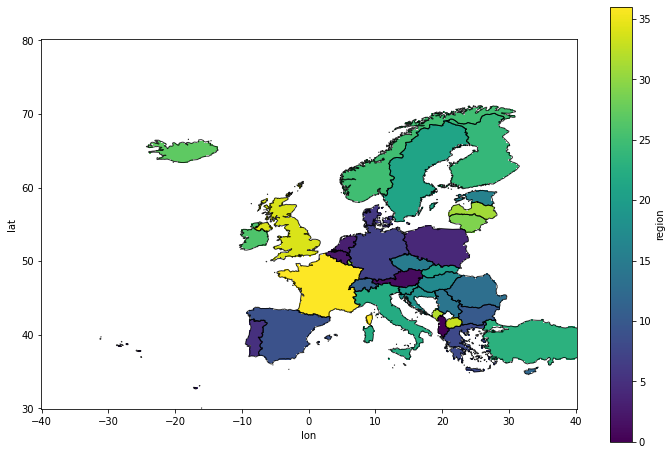

In [14]:
# Just to visualise
plt.figure(figsize=(12,8))
ax = plt.axes()
mask.plot(ax = ax)
nuts.plot(ax = ax, alpha = 0.8, facecolor = 'none', lw = 1)

In [26]:
def extract_nuts_TS(nc, nuts_mask_poly, lim_lat, lim_lon, nam_lat, nam_lon, ID_country):
    # Important: pay attention to incresing (or decreasin order of latitude)
    mask = nuts_mask_poly.mask(nc.isel(time = 0).sel(lat = slice(lim_lat[0],lim_lat[1]), lon  = slice(lim_lon[0], lim_lon[1])), lat_name=nam_lat, lon_name=nam_lon)
    lat = mask.lat.values
    lon = mask.lon.values
    var_country = list()
    meanvar_country = list()
    if ( ID_country == None ):
        for ID_REGION in range(0,37):
            print(ID_REGION)
            sel_mask = mask.where(mask == ID_REGION).values
            id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
            id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]
            out_sel = nc.sel(lat = slice(id_lat[0], id_lat[-1]), lon = slice(id_lon[0], id_lon[-1])).compute().where(mask == ID_REGION)
            var_country.append(out_sel)
            # For doing country average
            x = out_sel.groupby('time').mean(...)
            meanvar_country.append(x)
    else:
        print(ID_country)        
        sel_mask = mask.where(mask == ID_country).values
        id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
        id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]
        out_sel = nc.sel(lat = slice(id_lat[0], id_lat[-1]), lon = slice(id_lon[0], id_lon[-1])).compute().where(mask == ID_country)
        var_country.append(out_sel)
        # For doing country average
        x = out_sel.groupby('time').mean(...)
        meanvar_country.append(x)
        
    return(x)

In [27]:
t2m_CH = extract_nuts_TS(t2m_dat,nuts_mask_poly,lim_lat = [80, 30], lim_lon = [-40, 40], nam_lat='lat',nam_lon='lon', ID_country = ID_CH)

11


In [ ]:
mslp_CH = extract_nuts_TS(mslp_dat,nuts_mask_poly,lim_lat = [30, 80], lim_lon = [-40, 40], nam_lat='lat',nam_lon='lon', ID_country = ID_CH)

11


In [83]:
mslp_CH = extract_nuts_TS(mslp_dat, nuts_mask_poly, ID_country = ID_CH)

<ipython-input-81-2aa6f459c458>:3: UserWarning: No gridpoint belongs to any region. Returning an all-NaN mask.
  mask = nuts_mask_poly.mask(nc.isel(time = 0).sel(lat = slice(80,30), lon  = slice(-40, 40)), lat_name='lat', lon_name='lon')


11


IndexError: index 0 is out of bounds for axis 0 with size 0

In [122]:
def save_dataf(mdat, xvar, dout):
    df_ch = pd.DataFrame({'date':mdat['time'].values, xvar:mdat[xvar].values})
    # saving the dataframe 
    df_ch.to_csv(dir_out + 'df_'+ xvar + '_CH_1979-2021.csv', index = False, header=True)

    
    

In [123]:
dir_out = "/Users/noeliaotero/Documents/OCCR/data/data_CAS_ML/"

In [124]:
save_dataf(t2m_CH, 'T2MMEAN', dir_out)